In [14]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [15]:
# 生成人工数据集，y = wx + b + 噪声
def synthetic_data(w, b, num_examples) :
    X = torch.normal(0, 1, (num_examples, len(w)))
    # 前两个参数指定X中的数据来自 均值为0，标准差为1 的正态分布
    # 后一个参数为一个元组，用于指定X的形状
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    # 添加噪声
    return X, y.reshape((-1, 1))
    # 对y进行reshape，-1表示自动推断维度，1表示只有一列，这保证了y是一个列向量

In [16]:
true_w = torch.tensor([2, 3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
# 此处X的形状为(1000, 2)，w形状为(1, 2)
# 矩阵乘法和矩阵-向量乘法需要时刻检查维度问题
# 后者需要注意矩阵的列数和向量的长度相等

In [17]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-1.0778, -0.9444]) 
label: tensor([-1.1508])


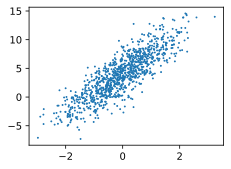

In [18]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)
# detach() 用于避免梯度计算，因为此处仅需用来画图
# 转换为numpy数组是为了与画图操作更兼容

In [19]:
# 抽取小批量数据方便后续更正模型，这还有利于提高效率和模型的泛化性
def data_iter(batch_size, features, labels) :
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    # 用于打乱抽取的indices，确保数据是随机抽取的
    for i in range(0, num_examples, batch_size) :
        # batch_indices为每个小批量的大小
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]
        # yeild为生成器函数，每次循环返回随机抽取的小批量features和labels

In [20]:
batch_size = 10

for X,y in data_iter(batch_size, features, labels) :
    print(X, '\n', y)
    break

tensor([[ 0.1516, -1.3637],
        [ 1.1074,  0.4256],
        [-1.5201,  1.5509],
        [-0.2704, -0.3045],
        [-0.7307,  1.3892],
        [-1.1012,  1.9468],
        [ 0.7820,  0.6383],
        [-0.5752,  0.5663],
        [ 1.7231,  0.5793],
        [-0.6542,  0.0180]]) 
 tensor([[-0.1358],
        [ 7.8562],
        [ 6.4514],
        [ 2.6234],
        [ 7.4654],
        [ 8.6257],
        [ 7.9192],
        [ 4.9806],
        [ 9.6141],
        [ 2.9574]])


#### 以上为建立人工数据，以下为训练线性回归模型

In [21]:
 # 初始化模型参数
w = torch.normal(0, 0.02, size = (2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [22]:
# 定义线性回归模型
def linreg(X, w, b) :
    return torch.matmul(X, w) + b

In [23]:
# 定义损失函数
def squared_loss(y_hat, y) :
    return (y_hat - y.reshape(y_hat.shape)) **2 / 2

In [24]:
# 定义优化算法（随机梯度下降）
def sgd(params, lr, batch_size) :
    with torch.no_grad() :
    # 临时禁用梯度计算，节省内存的同时使其内部的梯度计算不受影响
        for param in params :
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [26]:
# 训练
lr = 0.03
num_epochs = 3 # 训练次数
net = linreg
loss = squared_loss

for epoch in range(num_epochs) :
    for X, y in data_iter(batch_size, features, labels) :
        l = loss(net(X, w, b), y) # 使用小批量进行训练、更新模型
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad() :
        train_l = loss(net(features, w, b), labels) # 使用所有特征、标签显示当前训练轮的损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()): f}')

epoch 1, loss  0.056825
epoch 2, loss  0.000264
epoch 3, loss  0.000050


In [28]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([0.0013, 0.0004], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0006], grad_fn=<RsubBackward1>)
